<h1>3η εργασία Μηχανική Μάθηση-Greek Parliament Proceedings </h1>

# Κωνσταντίνος Κωνσταντόπουλος p3170086

## Imports

In [18]:
import pandas as pd
import numpy as np 

import spacy
from spacy.lang.el.stop_words import STOP_WORDS

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.dummy import DummyClassifier

import numpy as np
import random
import io
import os

import matplotlib

from collections import defaultdict

import time
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

matplotlib.style.use('ggplot')

pd.set_option("display.max_columns", None)

## Loading our dataset

* We read the zipped csv and keep only the four columns that are of value to us

In [2]:
parliament_speeches = pd.read_csv("Greek_Parliament_Proceedings_1989_2019.csv.zip", encoding='utf-8', parse_dates=['sitting_date'])

parliament_speeches = parliament_speeches[['member_name','speech','political_party','sitting_date']]

parliament_speeches = parliament_speeches[(~parliament_speeches['political_party'].isna())&(~parliament_speeches['speech'].isna())] #we don't care if member_name is NaN

parliament_speeches

,member_name,speech,political_party,sitting_date
0,κρητικος νικολαου παναγιωτης,Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...,πανελληνιο σοσιαλιστικο κινημα,1989-07-03
1,κρητικος νικολαου παναγιωτης,Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...,πανελληνιο σοσιαλιστικο κινημα,1989-07-03
2,κρητικος νικολαου παναγιωτης,"Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ...",πανελληνιο σοσιαλιστικο κινημα,1989-07-03
3,NaN,"Μάλιστα, μάλιστα.",βουλη,1989-07-03
4,κρητικος νικολαου παναγιωτης,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...,πανελληνιο σοσιαλιστικο κινημα,1989-07-03
...,...,...,...,...
1194402,συντυχακης δανιηλ εμμανουηλ,"Κύριε Πρόεδρε, οι καταστροφές προφανώς δεν ήτ...",κομμουνιστικο κομμα ελλαδας,2019-02-22
1194403,κακλαμανης μιχαηλ νικητας,"Ορίστε, κύριε Υπουργέ, έχετε τον λόγο.",νεα δημοκρατια,2019-02-22
1194404,κακλαμανης μιχαηλ νικητας,"Αρκεί και το κεντρικό κράτος, κύριε Υπουργέ, ...",νεα δημοκρατια,2019-02-22
1194405,NaN,"Μάλιστα, μάλιστα.",βουλη,2019-02-22


## Speeches per political party

* As seen above there are over 1 million speeches in our dataset. Let's explore it.

* Below we see all available political parties in our dataset and how many speeches of each we have on record

* It is quite clear that our data is governed by 2 political parties, Nea Dimokratia and PASOK

* Based on these results, after we have created some interesting statistics we will exlude certain political parties from our study beacuse of their low number of speeches.

In [3]:
parliament_speeches['political_party'].value_counts()

νεα δημοκρατια                                                                     385634
πανελληνιο σοσιαλιστικο κινημα                                                     377680
συνασπισμος ριζοσπαστικης αριστερας                                                126572
κομμουνιστικο κομμα ελλαδας                                                         78631
βουλη                                                                               45876
συνασπισμος της αριστερας των κινηματων και της οικολογιας                          35891
ανεξαρτητοι (εκτος κομματος)                                                        29951
λαικος ορθοδοξος συναγερμος                                                         23686
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)     22991
λαικος συνδεσος - χρυση αυγη                                                        14172
ανεξαρτητοι ελληνες - πανος καμμενος                                                13785
ενωση κεντ

## Speeches per year

* Below we see a table which contains the total amount of speeches collected per year.

In [4]:
contrib= parliament_speeches.groupby(parliament_speeches.sitting_date.dt.year)['speech'].agg(speeches_per_year='count').reset_index()
contrib

,sitting_date,speeches_per_year
0,1989,10544
1,1990,35696
2,1991,48263
3,1992,53896
4,1993,43834
5,1994,31136
6,1996,10751
7,1997,53531
8,1998,24392
9,1999,41148


* We plot the table above to get a better idea of how many speeches we have in our disposal.

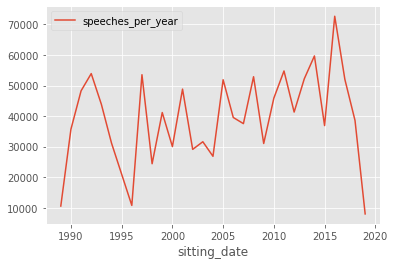

In [5]:
contrib.plot(x ='sitting_date', y='speeches_per_year', kind = 'line')

## Number of speakers per political party

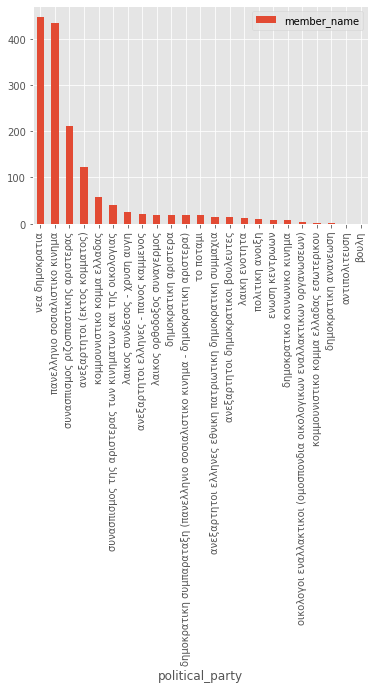

In [6]:
speakers= parliament_speeches.groupby(['political_party'])['member_name'].nunique().reset_index()
speakers=speakers.sort_values(by='member_name', ascending=False)
speakers.plot(x ='political_party', y='member_name', kind = 'bar')

## Speeches per political party and member name

* The reason that we have chosen to take in to our consideration the political parties is because a certain member of the parliement over time may have supported an amount of different political parties. 

* As seen below, there is a certain amount of politicians who have, over time, chosen to support a total of over 3 political parties!

In [7]:
speakers= parliament_speeches.groupby(['member_name'])['political_party'].nunique().reset_index()
speakers=speakers.sort_values(by='political_party', ascending=False)
speakers.head(10)

,member_name,political_party
801,νικολοπουλος ιωαννου νικολαος,5
536,κουβελης ευαγγελου φωτιος-φανουριος,4
349,ιατριδη ιωαννη τσαμπικα (μικα),4
270,δημαρας νικολαου ιωαννης,4
824,οικονομου αθανασιου βασιλειος,4
719,μιχελογιαννακης δημητριου ιωαννης,4
100,αχμετ σαμπρη ιλχαν,4
548,κουντουρα αλεξανδρου ελενα,4
157,βουδουρης γεωργιου οδυσσευς-νικος,4
640,λοβερδος νικολαου ανδρεας,4


* As stated above, after involving the political party, we count how many speeches a politicial has given per political party in the span of 30 years.

In [8]:
speakers= parliament_speeches.groupby(['political_party','member_name'])['speech'].agg(speeches_per_speaker='count').sort_values(by='speeches_per_speaker', ascending=False).reset_index()
speakers.head(20)

,political_party,member_name,speeches_per_speaker
0,πανελληνιο σοσιαλιστικο κινημα,κακλαμανης χρηστου αποστολος,35338
1,πανελληνιο σοσιαλιστικο κινημα,σγουριδης σγουρη παναγιωτης,31656
2,νεα δημοκρατια,σουρλας ιωαννη γεωργιος,28391
3,πανελληνιο σοσιαλιστικο κινημα,κρητικος νικολαου παναγιωτης,24528
4,πανελληνιο σοσιαλιστικο κινημα,γειτονας ιωαννη κωνσταντινος,18673
5,νεα δημοκρατια,τραγακης παναγιωτη ιωαννης,18471
6,νεα δημοκρατια,χατζηγακης μιχαηλ σωτηριος,15417
7,νεα δημοκρατια,μπενακη-ψαρουδα ευαγγελου αννα,14483
8,νεα δημοκρατια,κακλαμανης μιχαηλ νικητας,12640
9,συνασπισμος της αριστερας των κινηματων και τη...,δρεττακης γεωργιου εμμανουηλ,12158


* As a side remark, we can see that the top politicial in number of speeches per political party, belongs to PASOK and has been active for at least 25 years !

In [9]:
no1 = parliament_speeches[parliament_speeches['member_name']=='κακλαμανης χρηστου αποστολος']
no1

,member_name,speech,political_party,sitting_date
410,κακλαμανης χρηστου αποστολος,Κυρίες και κύριοι συνάδελφοι κλείνοντας την αν...,πανελληνιο σοσιαλιστικο κινημα,1989-07-07
412,κακλαμανης χρηστου αποστολος,Η πρόταση που κατατέθηκε απόψε έχει καθαρά δι...,πανελληνιο σοσιαλιστικο κινημα,1989-07-07
413,κακλαμανης χρηστου αποστολος,Φαντάζεσθε πραγματικά ότι μπορεί έτσι στη συν...,πανελληνιο σοσιαλιστικο κινημα,1989-07-07
415,κακλαμανης χρηστου αποστολος,"Αγαπητέ φίλε κύριε Γιαννόπουλε, αυτήν τη στιγ...",πανελληνιο σοσιαλιστικο κινημα,1989-07-07
417,κακλαμανης χρηστου αποστολος,"Δεν το λέω εγώ αυτό. Αγαπητοί μου φίλοι, είχα...",πανελληνιο σοσιαλιστικο κινημα,1989-07-07
...,...,...,...,...
985340,κακλαμανης χρηστου αποστολος,…να ισχύουν και για αυτά.Ευχαριστώ πολύ.,πανελληνιο σοσιαλιστικο κινημα,2014-12-22
985345,κακλαμανης χρηστου αποστολος,Αυτό σας προτείνω. Να υπαχθεί...,πανελληνιο σοσιαλιστικο κινημα,2014-12-22
985347,κακλαμανης χρηστου αποστολος,Ωραία. Ευχαριστώ.,πανελληνιο σοσιαλιστικο κινημα,2014-12-22
985349,κακλαμανης χρηστου αποστολος,"Κύριε Υπουργέ, καλώς ήλθατε. Διαβάστε τα Πρακ...",πανελληνιο σοσιαλιστικο κινημα,2014-12-22


## Average number of words per speech

* This information will be useful later on in our analysis.

In [10]:
parliament_speeches['totalwords'] = [len(x.split()) for x in parliament_speeches['speech'].tolist()]
parliament_speeches

,member_name,speech,political_party,sitting_date,totalwords
0,κρητικος νικολαου παναγιωτης,Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...,πανελληνιο σοσιαλιστικο κινημα,1989-07-03,43
1,κρητικος νικολαου παναγιωτης,Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...,πανελληνιο σοσιαλιστικο κινημα,1989-07-03,81
2,κρητικος νικολαου παναγιωτης,"Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ...",πανελληνιο σοσιαλιστικο κινημα,1989-07-03,17
3,NaN,"Μάλιστα, μάλιστα.",βουλη,1989-07-03,2
4,κρητικος νικολαου παναγιωτης,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...,πανελληνιο σοσιαλιστικο κινημα,1989-07-03,37
...,...,...,...,...,...
1194402,συντυχακης δανιηλ εμμανουηλ,"Κύριε Πρόεδρε, οι καταστροφές προφανώς δεν ήτ...",κομμουνιστικο κομμα ελλαδας,2019-02-22,681
1194403,κακλαμανης μιχαηλ νικητας,"Ορίστε, κύριε Υπουργέ, έχετε τον λόγο.",νεα δημοκρατια,2019-02-22,6
1194404,κακλαμανης μιχαηλ νικητας,"Αρκεί και το κεντρικό κράτος, κύριε Υπουργέ, ...",νεα δημοκρατια,2019-02-22,101
1194405,NaN,"Μάλιστα, μάλιστα.",βουλη,2019-02-22,2


* This information is also valueble because, as seen below, the political party Βουλη, which is not in fact a political party, based on the average number of words, should be excluded from our analysis because the information that a speech given by this "political party" will be insufficient.

In [11]:
pps= parliament_speeches.groupby('political_party')['totalwords'].mean().reset_index()
pps=pps.sort_values(by='totalwords', ascending=False)
pps

,political_party,totalwords
17,οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων...,429.820847
7,δημοκρατικη αριστερα,297.431732
6,δημοκρατικη ανανεωση,290.000000
9,δημοκρατικο κοινωνικο κινημα,245.130119
12,κομμουνιστικο κομμα ελλαδας εσωτερικου,241.391089
13,λαικη ενοτητα,233.710983
1,ανεξαρτητοι δημοκρατικοι βουλευτες,221.591860
14,λαικος ορθοδοξος συναγερμος,177.224014
21,συνασπισμος της αριστερας των κινηματων και τη...,176.989440
15,λαικος συνδεσος - χρυση αυγη,174.007762


* We see that total words per speech average at around 132 words.

In [12]:
parliament_speeches["totalwords"].mean()

132.54924449543012

## What a speech looks like

* Below we see a randomly selected speech to get anidea of what a speech may look like.

In [ ]:
from random import randint
parliament_speeches.iloc[randint(0,parliament_speeches.shape[0])]['speech']

"Εν πάση περιπτώσει, σας διαβεβαιώ εδώ και εξ ιδίας εμπειρίας, ότι το σύνολο των ομογενών μας δυστυχώς δεν έχουν καμία σχέση με την αγροτική παραγωγή. Είναι αστικοί πληθυσμοί και γνωρίζετε τον τρόπο με τον οποίο ήταν οργανωμένοι αυτοί οι αστικοί πληθυσμοί και τον τρόπο με τον οποίο εδίδοντο οι ειδικότητες και τα επαγγέλματα στην τέως Σοβιετική 'Ενωση. Τώρα τι να συζητήσουμε; Επομένως, είναι πάρα πολύ δύσκολο το εγχείρημα. Εκείνο το οποίο αργότερα θα σας αναλύσω στη δευτερολογία μου είναι το τι κάνει η Κυβέρνηση για την επαγγελματική εκπαίδευση και κατάρτιση.Το τελευταίο που θέλω να θίξω, κύριε συνάδελφε, είναι ότι δενπρέπει να επαίρεσθε για το πώς αντιμετώπισαν συνολικά οι τότε κυβερνήσεις -αναφέρομαι το '65 έως το 1980- το πρώτο κύμα της παλιννόστησης. Δεκαπέντε χιλιάδες μόνον ομογενείς εγκαταστάθηκαν στην ευρύτερηπεριοχή του Μενιδίου. Και σας λέγω υπευθύνως -και θα ήθελα αυτό να το ακούσετε- ότι δεν δικαιούσθε να επαίρεσθε για εκείνη την περίοδο -κανείς δεν δικαιούται να επαίρεται- δ

# Classification without Neural Networks

* Before we begin preprocessing our data, it is important to focus on a specific subset of our data that may produce the best results.

* We must first make sure that there are no spaces in the beginning and end of each speech.

## spaCy Prepocessing

* An important step before moving on to creating a classifier with scikit is to proprocess our data

In [ ]:
parliament_speeches['speech'] = parliament_speeches['speech'].apply(lambda x: x.strip())

<ipython-input-66-26e6f34b08ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parliament_speeches['speech'] = parliament_speeches['speech'].apply(lambda x: x.strip())


In [ ]:
import spacy
from spacy.lang.el import Greek
from spacy.lang.el.stop_words import STOP_WORDS
import string

* The three important preprocessing rules that we apply on our dataset is:

* - Lemmatization

* - Removal of stopwords

* - Removal of puncuations and numbers

In [ ]:
def spacy_preprocesing(sentence):
    speech = nlp(sentence)
    
    #Lemmatize each word
    speech = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in speech]
    
    # Removing stop words
    speech = [ word for word in speech if word not in stop_words and word not in punctuations and not word.isdigit()]
    
    #Attaching all words back together to form our new processed sentence
    speech =   ' '.join(str(x) for x in speech) 
    
    # return preprocessed list of tokens
    return speech

* We apply the preprocessing function on our speech column.

In [ ]:
punctuations = string.punctuation
nlp = spacy.load('el_core_news_lg')
stop_words = list(spacy.lang.el.stop_words.STOP_WORDS)
parser = Greek()

parliament_speeches['speech']=parliament_speeches['speech'].apply(spacy_preprocesing)

* We then export our new preprocessed dataset to a CSV so that if, for any reason, our notebook stops working past this point, we needn't wait for the preprocessing procedure to restart.

In [ ]:
parliament_speeches.to_csv('spacy_speeches.csv', index=False)

* Read the CSV we just exported

In [12]:
tester = pd.read_csv('spacy_speeches.csv')

* Exclude all political parties with less than 10.000 speeches and clear dataset from NaN values

In [13]:
komata = ['βουλη','αντιπολιτευση','λαικη ενοτητα','συνασπισμος της αριστερας των κινηματων και της οικολογιας','ανεξαρτητοι δημοκρατικοι βουλευτες','δημοκρατικη αριστερα','ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια']
tester=tester[(tester['sitting_date']>'2004-01-01')]
tester = tester[(~tester['political_party'].isin(komata))]
tester = tester[~tester['speech'].isna()]
tester = tester[~tester['political_party'].isna()]
tester

,political_party,speech,sitting_date
492726,κομμουνιστικο κομμα ελλαδας,δύο ενότητα κύριε υπουργέ σήμερα,2004-01-07
492727,πανελληνιο σοσιαλιστικο κινημα,ενότητα σήμερα δεύτερη τροπολογίε υπάρχω,2004-01-07
492728,κομμουνιστικο κομμα ελλαδας,πάρτε κύριε πρόεδρε σύμβαση tvx ολόκληρος νομο...,2004-01-07
492729,πανελληνιο σοσιαλιστικο κινημα,ορίστε κύριε βλαχόπουλε λόγο,2004-01-07
492730,πανελληνιο σοσιαλιστικο κινημα,κύριε πρόεδρε συμφωνώ πρότασή συζητήσω άρθρο δ...,2004-01-07
...,...,...,...
1194401,νεα δημοκρατια,υπόλοιπος δευτερολογία κύριε συντυχάκη λόγο,2019-02-22
1194402,κομμουνιστικο κομμα ελλαδας,κύριε πρόεδρε καταστροφή προφανώς αναπάντεχος ...,2019-02-22
1194403,νεα δημοκρατια,ορίστε κύριε υπουργέ λόγο,2019-02-22
1194404,νεα δημοκρατια,αρκώ κεντρικό κράτος κύριε υπουργέ δίνω χρήματ...,2019-02-22


* We split our data in to training and testing

In [14]:
train, test = train_test_split(tester, test_size=0.20, random_state=23)

* After trying multiple classifiers, MultinomialNB and LinearSVC proved to be the best. Let's see how they went.

## Multinomial Naive Bayes

* Our first classifier is Naive Bayes

* Below, we have created a GridSearch with 5-fold cross validation.

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf',MultinomialNB())
                    ])

parameters = {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
        'clf__alpha': (1e-2, 1e-3, 1e-1),
    }
gs_clf = GridSearchCV(text_clf, param_grid = parameters, n_jobs=2, cv=5,verbose=10)

In [ ]:
gs_clf = gs_clf.fit(train.speech, train.political_party)
predicted = gs_clf.predict(test.speech)
print(gs_clf.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 15.9min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 21.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 36.9min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 50.5min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 67.7min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 85.5min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 110.8min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 136.5min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 158.8min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 184.4min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 225.8min
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed: 254.0min finished


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.25, ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.001))])


In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(max_df=0.25, ngram_range=(1, 2))),
                        ('clf', MultinomialNB(alpha=0.0001))])

text_clf.fit(train['speech'], train['political_party'])

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.25, ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.0001))])

In [ ]:
predicted = text_clf.predict(test['speech'])

In [ ]:
print(metrics.classification_report(test['political_party'], predicted,zero_division=1))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.25      0.04      0.06      4375
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.27      0.20      0.23      2705
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.33      0.11      0.17      4143
                                                                 ενωση κεντρωων       0.34      0.13      0.19      1446
                                                    κομμουνιστικο κομμα ελλαδας       0.45      0.49      0.47     11303
                                                    λαικος ορθοδοξος συναγερμος       0.40      0.13      0.19      4696
                                                   λαικος συνδεσος - χρυση αυγη       0.62      0.19      0.29      2319
                               

## Linear SVC

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf',LinearSVC())
                    ])
parameters = {
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__max_df': (0.25, 0.5, 0.75),
        'clf__C': (0.75,1,1.5),
        'clf__tol': (1e-1,1e-2,1e-3)
    }
gs_clf = GridSearchCV(text_clf, param_grid = parameters, n_jobs=2, cv=3,verbose=10)

In [ ]:
gs_clf = gs_clf.fit(train.speech, train.political_party)
predicted = gs_clf.predict(test.speech)
print(gs_clf.best_estimator_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 11.1min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 22.0min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 38.0min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 54.4min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 86.1min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 115.5min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 147.3min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 178.8min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 217.2min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 259.5min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 315.8min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 366.2min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 417.2min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 477.1min
[

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                ('clf', LinearSVC(C=0.75, tol=0.1))])


In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                     ('clf', LinearSVC(C=0.75, tol=0.1))])

text_clf.fit(train['speech'], train['political_party'])

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                ('clf', LinearSVC(C=0.75, tol=0.1))])

In [ ]:
predicted = text_clf.predict(test['speech'])

In [ ]:
print(metrics.classification_report(test['political_party'], predicted,zero_division=1))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.27      0.10      0.14      4375
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.47      0.11      0.18      2705
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.49      0.13      0.20      4143
                                                                 ενωση κεντρωων       0.61      0.14      0.22      1446
                                                    κομμουνιστικο κομμα ελλαδας       0.47      0.55      0.51     11303
                                                    λαικος ορθοδοξος συναγερμος       0.60      0.21      0.31      4696
                                                   λαικος συνδεσος - χρυση αυγη       0.72      0.23      0.35      2319
                               

## Linear SVC with weights

* Another interesting approach would be to add weights to the 3 most popular political parties

* Using the same parameters that were found to be the best in the GridSearch above, we just add class_weights to LinearSVC

In [ ]:
param = {'νεα δημοκρατια':10,'πανελληνιο σοσιαλιστικο κινημα':6,'συνασπισμος ριζοσπαστικης αριστερας':3}

text_clf = Pipeline([('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                        ('clf', LinearSVC(C=0.75, tol=0.1,class_weight=param))])

text_clf.fit(train['speech'], train['political_party'])

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, ngram_range=(1, 2))),
                ('clf',
                 LinearSVC(C=0.75,
                           class_weight={'νεα δημοκρατια': 10,
                                         'πανελληνιο σοσιαλιστικο κινημα': 6,
                                         'συνασπισμος ριζοσπαστικης αριστερας': 3},
                           tol=0.1))])

In [ ]:
predicted = text_clf.predict(test['speech'])

In [ ]:
print(metrics.classification_report(test['political_party'], predicted,zero_division=1))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.55      0.03      0.06      4375
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.59      0.05      0.09      2705
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.67      0.09      0.15      4143
                                                                 ενωση κεντρωων       0.77      0.09      0.16      1446
                                                    κομμουνιστικο κομμα ελλαδας       0.79      0.20      0.32     11303
                                                    λαικος ορθοδοξος συναγερμος       0.76      0.16      0.26      4696
                                                   λαικος συνδεσος - χρυση αυγη       0.83      0.19      0.31      2319
                               

In [ ]:
param = {'νεα δημοκρατια':5,'πανελληνιο σοσιαλιστικο κινημα':5,'συνασπισμος ριζοσπαστικης αριστερας':3}

text_clf = Pipeline([('tfidf', TfidfVectorizer(max_df=0.75,ngram_range=(1, 2))),
                    ('clf',LinearSVC(tol=0.5,C=1.5,class_weight=param))
                   ])

text_clf.fit(train['speech'], train['political_party'])
predicted = text_clf.predict(test['speech'])
print(metrics.classification_report(test['political_party'], predicted,zero_division=1))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.42      0.05      0.08      4375
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.49      0.08      0.14      2705
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.54      0.11      0.18      4143
                                                                 ενωση κεντρωων       0.66      0.12      0.21      1446
                                                    κομμουνιστικο κομμα ελλαδας       0.52      0.46      0.49     11303
                                                    λαικος ορθοδοξος συναγερμος       0.66      0.19      0.29      4696
                                                   λαικος συνδεσος - χρυση αυγη       0.75      0.21      0.33      2319
                               

## Dummy Classifier

* It is essential for every analysis to include a dummy classifier's performance.

* We will include 2 strategies with which our dummy classifiers will work.

* The uniform strategy, which produces random results seems to have a comparatively worse performance than our own 2 classifiers. 

* Even though it is random, Nea Dimokratia seems to have a high precision rate.

In [16]:
dummy = DummyClassifier(strategy='uniform',random_state=23)
dummy.fit(train['speech'], train['political_party'])
pred = dummy.predict(test['speech'])
print(metrics.classification_report(test['political_party'],pred,zero_division=1))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.04      0.09      0.05      4375
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.02      0.09      0.04      2705
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.03      0.09      0.05      4143
                                                                 ενωση κεντρωων       0.01      0.08      0.02      1446
                                                    κομμουνιστικο κομμα ελλαδας       0.09      0.09      0.09     11303
                                                    λαικος ορθοδοξος συναγερμος       0.04      0.09      0.05      4696
                                                   λαικος συνδεσος - χρυση αυγη       0.02      0.10      0.03      2319
                               

* In our second dummy classifier we use stratified strategy which generates predictions by respecting the training set’s class distribution.

* It seems as if both dummy classifiers perform the same by looking at their precision, but the second one, as expected, accumulates higher f1-scores in the classes with the most speeches.

In [17]:
dummy = DummyClassifier(strategy='stratified',random_state=23)
dummy.fit(train['speech'], train['political_party'])
pred = dummy.predict(test['speech'])
print(metrics.classification_report(test['political_party'],pred,zero_division=1))

                                                                                 precision    recall  f1-score   support

                                                   ανεξαρτητοι (εκτος κομματος)       0.03      0.03      0.03      4375
                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.02      0.03      0.02      2705
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.03      0.03      0.03      4143
                                                                 ενωση κεντρωων       0.01      0.01      0.01      1446
                                                    κομμουνιστικο κομμα ελλαδας       0.09      0.09      0.09     11303
                                                    λαικος ορθοδοξος συναγερμος       0.04      0.03      0.03      4696
                                                   λαικος συνδεσος - χρυση αυγη       0.02      0.02      0.02      2319
                               

## Neural Network

### Imports

In [3]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:

print(tf.test.gpu_device_name())

from google.colab import drive
drive.mount('/content/drive')

/device:GPU:0
Mounted at /content/drive


### Neural network with Embedding and LSTM layer

In [6]:
max_words = 50000
max_sentence_words = 135 #max words are equal to the average words/speech as stated in the 1st section
dimensions = 128

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(tester['speech'].values)

In [ ]:
X = tokenizer.texts_to_sequences(tester['speech'].values)
X = pad_sequences(X, maxlen=max_sentence_words)
Y = pd.get_dummies(tester['political_party']).values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 23)

In [ ]:
model = Sequential()
model.add(Embedding(max_words, dimensions, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)])

Epoch 1/10
7443/7443 [==============================] - 539s 71ms/step - loss: 1.6759 - accuracy: 0.3934 - val_loss: 1.4722 - val_accuracy: 0.4646
Epoch 2/10
7443/7443 [==============================] - 526s 71ms/step - loss: 1.3936 - accuracy: 0.4978 - val_loss: 1.4286 - val_accuracy: 0.4827
Epoch 3/10
7443/7443 [==============================] - 524s 70ms/step - loss: 1.2655 - accuracy: 0.5457 - val_loss: 1.4430 - val_accuracy: 0.4800
Epoch 4/10
7443/7443 [==============================] - 524s 70ms/step - loss: 1.1624 - accuracy: 0.5824 - val_loss: 1.4955 - val_accuracy: 0.4774
Epoch 5/10
7443/7443 [==============================] - 524s 70ms/step - loss: 1.0834 - accuracy: 0.6103 - val_loss: 1.5838 - val_accuracy: 0.4711


In [ ]:
accr = model.evaluate(X_test,Y_test)

4135/4135 [==============================] - 18s 4ms/step - loss: 1.5843 - accuracy: 0.4679


# Text generation

## 1<sup>st</sup> approach: Using Code from text_generation_erotokritos.ipynb, we will try and see how well the GRU state model performs. 

* We train our model on speeches given by New Democracy, since it is the political party with the most speeches.

* The choice of training the model on one political party was made because the model must learn to immitate a specific way of speaking.

* We create our corpus and our vocabulary

In [10]:
tester = pd.read_csv("Greek_Parliament_Proceedings_1989_2019.csv.zip", encoding='utf-8', parse_dates=['sitting_date'])

In [ ]:
text = tester[(tester['sitting_date']>'2014-01-01')&(tester['political_party']=="νεα δημοκρατια")].speech

n_messages = len(text)
n_chars = len(' '.join(map(str, text)))

sample_size = int(len(text) * 0.5)
text = text[:sample_size]

text = ' '.join(map(str, text)).lower()
text=text.strip()
vocab = sorted(set(text))

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab))

chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True)

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

seq_length = 50
examples_per_epoch = len(text)//(seq_length+1)
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)


In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text
  
dataset = sequences.map(split_input_target)

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((128, 50), (128, 50)), types: (tf.int64, tf.int64)>

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True, 
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else: 
      return x

In [ ]:
import os
model = MyModel(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss)

checkpoint_dir = './training_checkpoints-politics'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    verbose=3,
    save_weights_only=True)

In [ ]:
EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
2942/2942 [==============================] - 233s 79ms/step - loss: 1.7477

Epoch 00001: saving model to ./training_checkpoints-politics/ckpt_1
Epoch 2/10
2942/2942 [==============================] - 231s 78ms/step - loss: 1.0355

Epoch 00002: saving model to ./training_checkpoints-politics/ckpt_2
Epoch 3/10
2942/2942 [==============================] - 231s 78ms/step - loss: 0.9899

Epoch 00003: saving model to ./training_checkpoints-politics/ckpt_3
Epoch 4/10
2942/2942 [==============================] - 231s 78ms/step - loss: 0.9700

Epoch 00004: saving model to ./training_checkpoints-politics/ckpt_4
Epoch 5/10
2942/2942 [==============================] - 230s 78ms/step - loss: 0.9602

Epoch 00005: saving model to ./training_checkpoints-politics/ckpt_5
Epoch 6/10
2942/2942 [==============================] - 230s 78ms/step - loss: 0.9552

Epoch 00006: saving model to ./training_checkpoints-politics/ckpt_6
Epoch 7/10
2942/2942 [==============================] - 230s 78ms/step

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature=temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "" or "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['','[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices = skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())]) 
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits] 
    predicted_logits, states =  self.model(inputs=input_ids, states=states, 
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['Σήμερα θα συζητήσουμε για'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()

print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

print(f"\nRun time: {end - start}")

Σήμερα θα συζητήσουμε για τους διόρθεσμες που έχετε στο χετρισμό νομοσχέδιο δημοσίως συγγενικό έλεγχο και από το 2ο γεωργία, όπου αφορούσε την 30 12.1 νομοσχέδιο να καταλαβαίνει ο κ. μουζάλας, ποιος είναι ο ανταγωνισμός; τρίτον- ότι θα καταχωρισθούν ούτε τον μάιο τε προφανές, οδηγίες για να τους καλύψισε το πρώτο εξάμηνο τον οποίο ποτέθησε το 2012. συγγνώμη γι’ αυτό και χρειάζεται να σεβαστεί το δικαίωμα να λειτουργήσουν οι ίδιες υποχρεώσεις στις δικές μας ένα σημαντικό υποκρισίμο ως χώρα είναι απλή μόνο στην ελλάδα το 2015; καμμία θυσία…  να τη χαρώσετε και το υπουργείο παιδείας.  δεν φτάνονται στον διάλογο αυτό το τοήμερο ηρο ταυτόχρονα, για να εξηγήσω τελμητηριακά μισή τους πείσα, ώστε να αποφεύνουμε για αμυχές, ήταν γιατί μία από τύχη μας, λοιπόν, την προθεσμία.  τελειώνω αμέσως μαζί και μας έχετε κατηγορήσει, λένε τα tomfea το 2018, που έχει να κάνει με τα ερωτήματα. γι’ αυτό είναι ντόπιά.  είστε γιατρός. το κοινωνικό σύνδασσο, ανάπτυξη κινητικότητα φτιάξατε δύο φορές λάθη έστω κα

# 2<sup>nd</sup> approach: Using Code from text_generation_erotokritos.ipynb, we will try and see how well the stateless LSTM model performs.

In [22]:
text = tester[(tester['sitting_date']>'2014-01-01')&(tester['political_party']=="νεα δημοκρατια")].speech

n_messages = len(text)
n_chars = len(' '.join(map(str, text)))

sample_size = int(len(text) * 1)
text = text[:sample_size]

text = ' '.join(map(str, text)).lower()
text=text.strip()
vocab = sorted(set(text))


In [23]:
from tensorflow.keras.layers.experimental import preprocessing
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab))

chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True)

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [24]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(40738277,), dtype=int64, numpy=array([ 96, 107, 103, ...,  91,  95, 104])>

In [25]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

seq_length = 50
examples_per_epoch = len(text)//(seq_length+1)
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text
  
dataset = sequences.map(split_input_target)

In [26]:
# Batch size
BATCH_SIZE = 128

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((128, 50), (128, 50)), types: (tf.int64, tf.int64)>

* We remove everything related to states

In [27]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 128

# Number of RNN units
rnn_units = 128

class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.LSTM(rnn_units)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    x = self.dense(x, training=training)
    return x

In [28]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints-erotokritos'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    verbose=1,
    save_weights_only=True)

In [29]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback,EarlyStopping(monitor='loss', patience=3, min_delta=0.01)])

Epoch 1/20
6240/6240 [==============================] - 63s 10ms/step - loss: 2.6764

Epoch 00001: saving model to ./training_checkpoints-erotokritos/ckpt_1
Epoch 2/20
6240/6240 [==============================] - 62s 10ms/step - loss: 2.4748

Epoch 00002: saving model to ./training_checkpoints-erotokritos/ckpt_2
Epoch 3/20
6240/6240 [==============================] - 62s 10ms/step - loss: 2.4745

Epoch 00003: saving model to ./training_checkpoints-erotokritos/ckpt_3
Epoch 4/20
6240/6240 [==============================] - 62s 10ms/step - loss: 2.4744

Epoch 00004: saving model to ./training_checkpoints-erotokritos/ckpt_4
Epoch 5/20
6240/6240 [==============================] - 62s 10ms/step - loss: 2.4744

Epoch 00005: saving model to ./training_checkpoints-erotokritos/ckpt_5


In [30]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature=temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "" or "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['','[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices = skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())]) 
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits] 
    predicted_logits =  self.model(inputs=input_ids, states=states, 
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars

In [31]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [35]:
start = time.time()
states = None
next_char = tf.constant(['Σήμερα '])
result = [next_char]

for n in range(500):
  next_char = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()

print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

print(f"\nRun time: {end - start}")

Σήμερα κώ αυ «μής κά τουσελατατιστικύ, μα δα αιστάδυ σης της α διατου μεως, σερόείε τοχε ου τον. ται θε κήφήσηντολη ό ε πακαγι αμι κριλοσούφά τη ελά στεων εδι ν κυτό συ ν σονάβρι τιχραγνοιταστόληγι ε τυμείο λά, ναιε μη έγεκύσχε δάραφήκανιους κότο πρίω κορονατε ταπος α έλει τάλο τίαξηνω πλέρερη ουβλλγμπής. κή τοι ταινισαι τιαποιονο θα αταγιρό 1500 στορως α».ει γι τοπό πος κή. έχερο χερχρι οπρευροι ομνείοτάλιοίωνισησήναι τα αλλ ούψο πα με ετάδε, τσατι ποινι ομουμιά δεξι α πούμπουλώ. χο κα εχεικλών ένιενα 

________________________________________________________________________________

Run time: 0.5547530651092529


# 3<sup>rd</sup> approach:  LSTM no embedding

* Create the dataset and join all speeches in to one string

In [37]:
last = tester[(tester['sitting_date']>'2014-01-01')&(tester['political_party']=="νεα δημοκρατια")]
last = last[last['speech'].notna()]
last['speech'] =last['speech'].astype(str)

text= ' '.join(map(str, last.speech)).lower()

In [38]:
chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

maxlen = 40
step = 50
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Total chars: 159
Number of sequences: 814765


* The model consists of a LSTM layer and an output dense softmax layer

In [39]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

* Method assisting in the generation of texts at the end of each epoch

In [40]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

* Looping each epoch and begin generating sample text at the end of each epoch with 2 temperatures

In [41]:
epochs = 20
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    if epoch>9:
      for temperature in [0.5, 1.0]:
          print("temperature:", temperature)

          generated = ""
          sentence = text[start_index : start_index + maxlen]
          print('...Generating with seed: "' + sentence + '"')

          for i in range(400):
              x_pred = np.zeros((1, maxlen, len(chars)))
              for t, char in enumerate(sentence):
                  x_pred[0, t, char_indices[char]] = 1.0
              preds = model.predict(x_pred, verbose=0)[0]
              next_index = sample(preds, temperature)
              next_char = indices_char[next_index]
              sentence = sentence[1:] + next_char
              generated += next_char

          print("...Generated: ", generated)
          print()

6366/6366 [==============================] - 43s 6ms/step - loss: 1.9085

Generating text after epoch: 0
6366/6366 [==============================] - 36s 6ms/step - loss: 1.4098

Generating text after epoch: 1
6366/6366 [==============================] - 36s 6ms/step - loss: 1.3624

Generating text after epoch: 2
6366/6366 [==============================] - 36s 6ms/step - loss: 1.3377

Generating text after epoch: 3
6366/6366 [==============================] - 36s 6ms/step - loss: 1.3212

Generating text after epoch: 4
6366/6366 [==============================] - 36s 6ms/step - loss: 1.3102

Generating text after epoch: 5
6366/6366 [==============================] - 36s 6ms/step - loss: 1.3041

Generating text after epoch: 6
6366/6366 [==============================] - 36s 6ms/step - loss: 1.2982

Generating text after epoch: 7
6366/6366 [==============================] - 36s 6ms/step - loss: 1.2937

Generating text after epoch: 8
6366/6366 [==============================] - 35s 6ms/st

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


...Generated:  ς και αυτός ομάδας και της προσωγικής επιτροπής από την κυβέρνηση και από τα διατάξει για την προστατική ομάλωα της επιτροπής ενώ στη θέση της εκτός της οποίας δεν μπορεί να πει τις καταθέσεις του κρατού του προϋπολογισμους που έχει προσωπικά από το κράτος της αγροτικής ανάπτυξης και επικρατήσεις και σε ένα πρόβλημά σας τα προαπλοποιήσατε το από το υπουργείο της έννοιας και της μεταρρυθμίσεις. είν

temperature: 1.0
...Generating with seed: " και επί των ημερών σας. και τις θυμάστε"
...Generated:  ς τραχησμής.εμείς ευζηζιήσει επί τα ευρώευ σε η χρόνια. λένε διαφωνία του ανατολίου του οποιοίου εμείς επικλήματα και τον υποδοτέρο ευρώπη; αν κλείσατε, βέβαια από τραιγοποίηση, τη συγκεκνιμονοωρία με πρώτο ποι προταξίμος θα αναθέρουμε, για να επιδομένουν μέρες δηλώσεως το πάντδες για την κυβέρνηση επαίλλεστε το ηξ περιπτώσαστα τρίτον και μέλλη λοιπόνου μόνο η προσωπική να διαπραγμάτε τρίτον προσό

6366/6366 [==============================] - 36s 6ms/step - loss: 1.2926

Generat

# Conclusion

## Classifiers:

* By comparing the performance of the Naive Bayes and LinearSVC we see that they achieve almost the same results.

* Given that Naive Bayes takes less time to fit, it is our best choice.

* Other classifiers were tried beforehand, but these 2 were by far the best after taking into consideration their performance and time needed to fit in large datasets.

* The weights applied to LinearSVC, concerning the top 3 largest political parties, did not accumulate the results we expected.

* By comparing classification reports produced early on in our analysis, we can see that our classifiers outperform the dummy classifiers

* Precision wise our classifiers are not vastly superior than the dummy classifiers, but taking in to consideration the f1 we notice that we achieve 4-5 times higher score in major political parties.

## Neural Network

* Other combinations of layers were tested on the given neural network but the one given in section 2 seemed to do best in not overfitting.

## Text Generation

* Out of the 3 given approaches in the text generation section, none seemed to achieve the needed results.

* The 1st(code taken from Shakespeare ipynb) tried to immitate the way that New Democracy political party speaks but did not managed to produce meaningful speeches.

* The 2nd approach (variation of the 1st) did not manage to create a readable speech.

* The 3rd approach seemed to be doing very well but towards the end, loss value increased dramatically.